In [1]:
import numpy as np
from matplotlib.pylab import *

In [2]:
# Determines if a bit represents spin-up or spin-down
def isKthBitSet(n, k): 
    if n & (1 << k): 
        return 1 
    else: 
        return 0

In [3]:
def factorial(n):
    if n < 2:
        return 1
    else:
        return n*factorial(n-1)

In [4]:
def find_state(state,configs,N,M):
    for n in range(M):
        for k in range(2*N):
            if state[k] != configs[n,k]:
                break
        else:
            return n
    print('State Not Found')
    return 'Wrong'

In [5]:
def HubbardModel(Nx,Ny,U,mu,T):
    
    #site numbers, coordinates and phases
    N = Nx*Ny
    
    X = np.zeros(N,int)
    Y = np.zeros(N,int)

    # Given coordinates, returns the site number
    site = np.zeros([Nx,Ny],int)

    # Given the site number, returns AFM phases
    phase = np.zeros(N)

    k = 0
    for x in range(Nx):
        for y in range(Ny):
            phase[k] = (-1)**(x+y)
            site[x,y] = k
            X[k] = x
            Y[k] = y
            k += 1
    
    NumT  = len(T)
    NumMu = len(mu)
    
    Z    = np.zeros([NumT,NumMu])
    E    = np.zeros([NumT,NumMu])
    E2   = np.zeros([NumT,NumMu])
    rho  = np.zeros([NumT,NumMu])
    Mag  = np.zeros([NumT,NumMu])
    Mag2 = np.zeros([NumT,NumMu])
    m2   = np.zeros([NumT,NumMu])
    Saf  = np.zeros([NumT,NumMu])
    D    = np.zeros([NumT,NumMu])
    Mtot = 0
    
    # CoNumTructing the base kets, and calculating M and S^AFM for each ket

    # This is the loop over total number of particles sectors.
    for p in range(2*N+1):

    # UncommeNumT for Test #1:
    #for p in [1]:

        # This is the loop over total spin in the z direction
        for totSz in range(max(-p,-2*N+p),min(p+1,2*N-p+1),2):

            # Total number of up or down spin particles
            Nup = (p + totSz)//2
            Ndown = (p - totSz)//2

            # We know the size of the sub Hilbert space for this p and totSz. 
            M = factorial(N)**2//factorial(Nup)//factorial(N-Nup)//factorial(Ndown)//factorial(N-Ndown)
            #print(p,totSz,Nup,Ndown, M)
            Mtot += M

            particles = np.zeros([M,2*N], int)
            state = np.zeros(2*N, int)
            Dj = np.zeros(M)
            m2j = np.zeros(M)
            Safj = np.zeros(M)

            l = 0
            for n in range(4**N):
                NupSum = 0
                NdownSum = 0
                for i in range(0,2*N,2):
                    state[i] = isKthBitSet(n, i)
                    NupSum += state[i]
                for i in range(1,2*N,2):
                    state[i] = isKthBitSet(n, i)
                    NdownSum += state[i]
                if NupSum + NdownSum == p and NupSum - NdownSum == totSz:
                    particles[l,:] = state[:]
                    for i in range(N):

                        # Double occupancy is n_iup * n_idown
                        Dj[l] += particles[l,2*i]*particles[l,2*i+1]
                        m2j[l] += (particles[l,2*i]-particles[l,2*i+1])**2
                        
                        # Structure factor is made up of Sz_i * Sz_j
                        for j in range(N):
                            Safj[l] += (particles[l,2*i]-particles[l,2*i+1])*(particles[l,2*j]-particles[l,2*j+1])*phase[i]*phase[j]
                    l += 1

            if l != M:
                priNumT('Something Wrong!', p,totSz,l,M)

            # Constructing the Hamiltonian matrix
            H = np.zeros([M,M])

            for n in range(M):

                # Here, the interaction is diagonal
                H[n,n] += U*Dj[n] - U/2*p + U/4

                # The off-diagonal hopping terms
                for i in range(N):
                    
                    # SiteNum is the site number for x or y neighbors
                    for SiteNum in [site[(X[i]+1)%Nx,Y[i]], site[X[i],(Y[i]+1)%Ny]]:

                        # s is for up or down spin
                        for s in range(2):
                            
                            new_state = np.copy(particles[n,:])

                            if particles[n,2*i+s] == 1 and particles[n,2*SiteNum+s] == 0:
                                new_state[2*i+s] = 0
                                new_state[2*SiteNum+s] =  1
                                m = find_state(new_state,particles,N,M)
                                H[n,m] -= t
                            elif particles[n,2*i+s] == 0 and particles[n,2*SiteNum+s] == 1:
                                new_state[2*i+s] =  1
                                new_state[2*SiteNum+s] = 0
                                m = find_state(new_state,particles,N,M)
                                H[n,m] -= t

            # Diagonalizing the matrix
            e, v = np.linalg.eigh(H)
            #2 site 2 configurations as example
            #N sites and N configurations
            if M == N: 
                np.savetxt('plot1_eigenvals_U%d.dat' % U, e[:])

            Safa = np.zeros(M)
            Da   = np.zeros(M)
            m2a  = np.zeros(M)
            for n in range(M):
                Safa[n] = np.sum(v[:,n]**2*Safj[:])
                Da[n]   = np.sum(v[:,n]**2*Dj[:])
                m2a[n]  = np.sum(v[:,n]**2*m2j[:])

            for iT in range(NumT):
                for imu in range(NumMu):
                    Boltzman = np.exp(-(e[:]-mu[imu]*p)/T[iT])
                    Z[iT,imu]    += np.sum(Boltzman)
                    E[iT,imu]    += np.sum(e[:]*Boltzman[:])
                    E2[iT,imu]   += np.sum(e[:]**2*Boltzman[:])
                    rho[iT,imu]  += np.sum(p*Boltzman[:])
                    Mag[iT,imu]  += np.sum(totSz*Boltzman[:])
                    Mag2[iT,imu] += np.sum(totSz**2*Boltzman[:])
                    Saf[iT,imu]  += np.sum(Safa[:]*Boltzman[:])
                    D[iT,imu]    += np.sum(Da[:]*Boltzman[:])
                    m2[iT,imu]   += np.sum(m2a[:]*Boltzman[:])

    E    /= Z
    E2   /= Z
    rho  /= Z
    Mag  /= Z
    Mag2 /= Z
    Saf  /= Z
    D    /= Z
    m2   /= Z
    print(Mtot)

    return rho, E, E2, rho, Mag, Mag2, Saf, D, m2, 
    #return e
    

4096


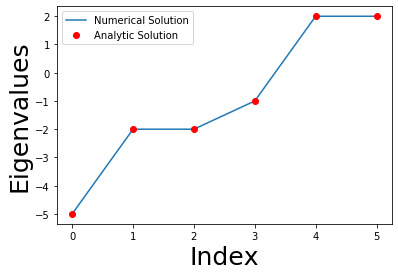

In [6]:

Nx = 2
Ny = 3
N = Nx * Ny
t = 1.
U = 4.
mu = [0.0]
NumT = 10
T = np.logspace(-1,1,NumT)

e = HubbardModel(Nx,Ny,U,mu,T)

E_particle = [] 
for numx in range(Nx):
    k_x = 2*np.pi*numx/Nx
    for numy in range(Ny):
        k_y = 2*np.pi*numy/Ny
        
        E_particle.append(-2*t*(np.cos(k_x)+np.cos(k_y))-U/4)

vals  = np.loadtxt('plot1_eigenvals_U%d.dat' % U)
plot(vals, label = 'Numerical Solution')
plot(E_particle,'ro', label = 'Analytic Solution')
legend()

xlabel('Index', fontsize=25)
ylabel('Eigenvalues', fontsize=25)
show()

4


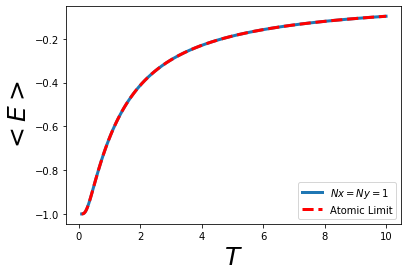

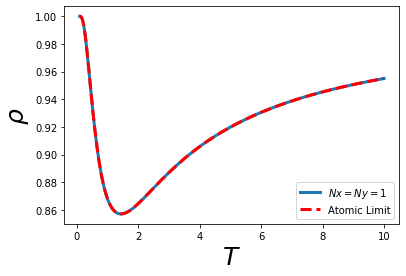

In [7]:
Nx = 1
Ny = 1
N = Nx *  Ny
t = 1.
U = 4.
mu = [-1.0]
NumT = 100
T = np.logspace(-1,1,NumT)
beta = 1/T

rho, E, E2, rho, Mag, Mag2, Saf, D, m2 = HubbardModel(Nx,Ny,U,mu,T)

def Z1(beta,mu,U): 
    return np.exp(-beta*U/4) + 2*np.exp(beta*(mu+U/4)) + np.exp(-beta*(U/4-2*mu))

def E1(beta,mu,U): 
    return (U/4*np.exp(-beta*U/4) - 2*(U/4)*np.exp(beta*(mu+U/4)) + (U/4)*np.exp(-beta*(U/4-2*mu)))/Z1(beta,mu,U)

def rho1(beta,mu,U):  
    return 2*(np.exp(beta*(mu+U/4))+np.exp(-beta*(U/4-2*mu)))/Z1(beta,mu,U)
    
def D1(beta,mu,U):  
    return np.exp(-beta*(U/4-2*mu))/Z1(beta,mu,U)
                                       
def m21(beta,mu,U):
    return rho1(beta,mu,U) - 2*D1(beta,mu,U)    

                                       
mu = -1.

plot(T,E/N,linewidth=3,label='$Nx=Ny=1$')
plot(T,E1(beta,mu,U),'r--',linewidth=3,label='Atomic Limit')
legend(loc='lower right')
xlabel('$T$', fontsize=25)
ylabel('$<E>$', fontsize=25)
show()

plot(T,rho/N,linewidth=3,label='$Nx=Ny=1$')
plot(T,rho1(beta,mu,U),'r--',linewidth=3,label='Atomic Limit')
legend(loc='lower right')
xlabel('$T$', fontsize=25)
ylabel('$\\rho$', fontsize=25)
show()

4096


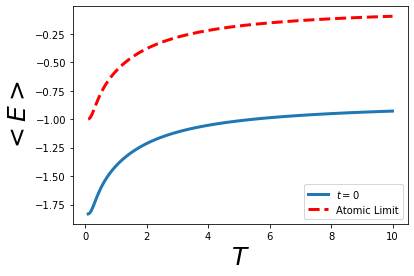

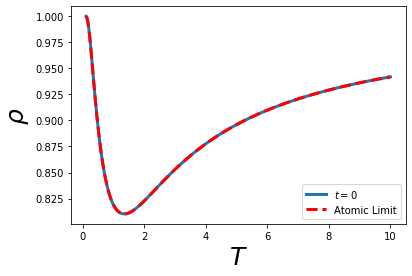

In [8]:

Nx = 2
Ny = 3
N = Nx*Ny
t = 0.0
U = 4.0
mu = [-1.3]
NT = 100
T = np.logspace(-1,1,NT)
beta = 1/T

rho, E, E2, rho, Mag, Mag2, Saf, D, m2 = HubbardModel(Nx,Ny,U,mu,T)

# Partition function
def Z1(beta,mu,U): 
    return np.exp(-beta*U/4) + 2*np.exp(beta*(mu+U/4)) + np.exp(-beta*(U/4-2*mu))

# Energy
def E1(beta,mu,U): 
    return (U/4*np.exp(-beta*U/4) - 2*(U/4)*np.exp(beta*(mu+U/4)) + (U/4)*np.exp(-beta*(U/4-2*mu)))/Z1(beta,mu,U)

# Occupation
def rho1(beta,mu,U):  
    return 2*(np.exp(beta*(mu+U/4))+np.exp(-beta*(U/4-2*mu)))/Z1(beta,mu,U)

# Double occupancy
def D1(beta,mu,U):  
    return np.exp(-beta*(U/4-2*mu))/Z1(beta,mu,U)

# Local moment
def m21(beta,mu,U):
    return rho1(beta,mu,U) - 2*D1(beta,mu,U)

mu = -1.3

plot(T,E/N,linewidth=3,label='$t=0$')
plot(T,E1(beta,mu,U),'r--',linewidth=3,label='Atomic Limit')
legend(loc='lower right')
xlabel('$T$', fontsize=25)
ylabel('$<E>$', fontsize=25)
show()

plot(T,rho/N,linewidth=3,label='$t=0$')
plot(T,rho1(beta,mu,U),'r--',linewidth=3,label='Atomic Limit')
legend(loc='lower right')
xlabel('$T$', fontsize=25)
ylabel('$\\rho$', fontsize=25)
show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


4096


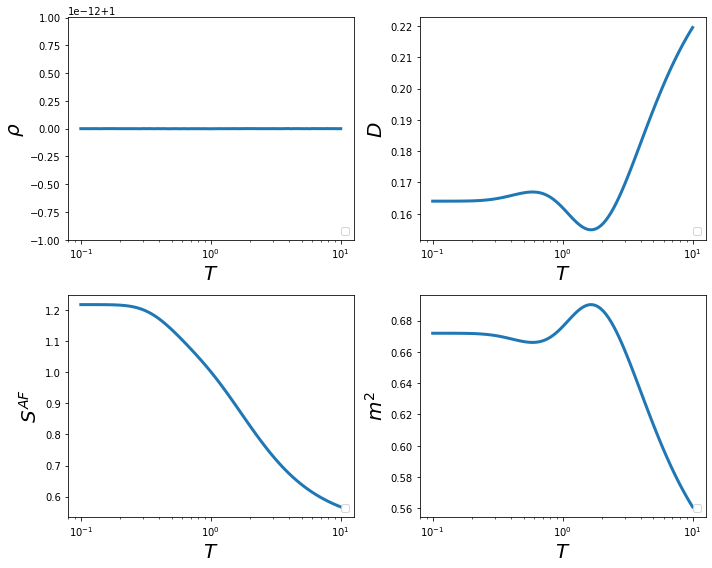

In [9]:

Nx = 2
Ny = 3
N = Nx*Ny
t = 1.0
U = 5.0
mu = [0.0]
NT = 100
T = np.logspace(-1,1,NT)
beta = 1/T

rho, E, E2, rho, Mag, Mag2, Saf, D, m2 = HubbardModel(Nx,Ny,U,mu,T)

figure(figsize=(10,8))
subplot(221)
plot(T,rho/N,linewidth=3)
legend(loc='lower right')
xlabel('$T$', fontsize=20)
ylabel('$\\rho$', fontsize=20)
xscale('log')

subplot(222)
plot(T,D/N,linewidth=3)
legend(loc='lower right')
xlabel('$T$', fontsize=20)
ylabel('$D$', fontsize=20)
xscale('log')

subplot(223)
plot(T,Saf/N,linewidth=3)
legend(loc='lower right')
xlabel('$T$', fontsize=20)
ylabel('$S^{AF}$', fontsize=20)
xscale('log')

subplot(224)
plot(T,m2/N,linewidth=3)
legend(loc='lower right')
xlabel('$T$', fontsize=20)
ylabel('$m^2$', fontsize=20)
xscale('log')

tight_layout()
show()

/home/cverdoza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:140: RuntimeWarning: overflow encountered in multiply
/home/cverdoza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: overflow encountered in double_scalars
/home/cverdoza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in double_scalars
/home/cverdoza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in multiply
/home/cverdoza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:145: RuntimeWarning: invalid value encountered in multiply
/home/cverdoza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: overflow encountered in multiply
/home/cverdoza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:143: RuntimeWarning: overflow encountered in multiply
/home/cverdoza/anaconda3/lib/python3.7/site-packages/ipykernel_launche

4096


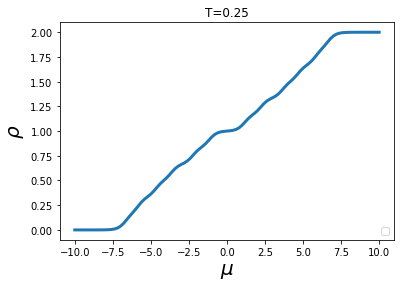

In [10]:

Nx = 2
Ny = 3
N = Nx*Ny
t = 1.0
U = 5.0
mu = np.linspace(-U-5,U+5,101)
NT = 100
T = np.logspace(-1,1,NT)
beta = 1/T

rho, E, E2, rho, Mag, Mag2, Saf, D, m2 = HubbardModel(Nx,Ny,U,mu,T)

plot(mu,rho[20,:]/N,linewidth=3)
title('T=%.2f' % T[20])
legend(loc='lower right')
xlabel('$\mu$', fontsize=20)
ylabel('$\\rho$', fontsize=20)

show()

4096
Done with U= 0
4096
Done with U= 2
4096
Done with U= 4
4096
Done with U= 6
4096
Done with U= 8
4096
Done with U= 10
4096
Done with U= 12
4096
Done with U= 14
4096
Done with U= 16
4096
Done with U= 18
4096
Done with U= 20
4096
Done with U= 22
4096
Done with U= 24


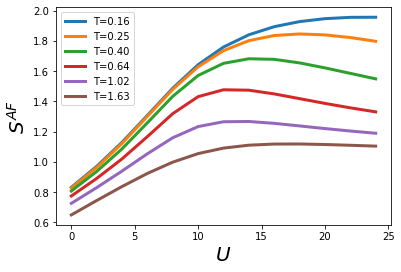

In [11]:

Nx = 2
Ny = 3
N = Nx*Ny
t = 1.0
u = np.arange(0,25,2)
mu = [0.0]
NT = 100
T = np.logspace(-1,1,NT)

SAF = []
for U in u:
    rho, E, E2, rho, Mag, Mag2, Saf, D, m2 = HubbardModel(Nx,Ny,U,mu,T)
    print('Done with U=',U)
    
    SAF.append(Saf)

SAF = np.array(SAF)

for iT in [10,20,30,40,50,60]:
    plot(u,SAF[:,iT]/N,linewidth=3,label='T=%.2f' % T[iT])
legend(loc='upper left')
xlabel('$U$', fontsize=20)
ylabel('$S^{AF}$', fontsize=20)

show()

16
64
256
1024
4096
(5, 100, 1)


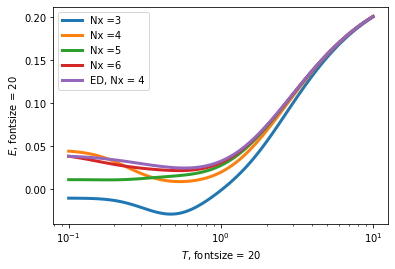

In [11]:
t = 1.0
U = 8.
mu = [0.0]
NT = 100
T = np.logspace(-1,1,NT)
Ny = 1

d = []
for Nx in range(2,7):
    N = Nx*Ny
    rho, E,E2, rho, Mag, Mag2, Saf, D, m2 = HubbardModel(Nx,Ny,U,mu,T)
    d.append(D)
d = np.array(d)
print(np.shape(d))
    
for M in range(4):
    plot(T,d[M+1,:,0]-d[M,:,0],linewidth = 3, label = 'Nx =%d'% (M+3))
plot(T,d[4,:,0]/6, linewidth = 3, label = 'ED, Nx = 4')

legend(loc = 'upper left')
xlabel('$T$, fontsize = 20')
ylabel('$E$, fontsize = 20')
xscale('log')
show()    

In [12]:
def Heis(T, J, Nx, Ny):
    NT = len(T)
    N = Nx*Ny

    phase = np.zeros(N)
    X = np.zeros(N,int)
    Y = np.zeros(N,int)
    site = np.zeros([Nx,Ny],int)

    k = 0
    for x in range(Nx):
        for y in range(Ny):
            phase[k] = (-1)**(x+y)
            site[x,y] = k
            X[k] = x
            Y[k] = y
            k += 1
            
    Z = np.zeros(NT)
    E = np.zeros(NT)
    E2 = np.zeros(NT)
    Mag = np.zeros(NT)
    Mag2 = np.zeros(NT)
    Saf = np.zeros(NT)

    # Contructing the base kets, and calculating M and S^AFM for each ket

    # This is the loop over total Sz sectors.
    for totSz in range(-N,N+1,2):

        # We know the size of the sub Hilbert space for this totSz. What is it?
        M = factorial(N)//factorial(totSz)//factorial(N-totSz)

        spins = np.zeros([M,N], int)
        confg = np.zeros(N, int)
        Mj = np.zeros(M)
        Safj = np.zeros(M)

        l = 0
        for n in range(2**N):
            Sz_sum = 0
            for i in range(N):
                confg[i] = isKthBitSet(n, i)
                Sz_sum += confg[i]
            if Sz_sum == totSz:
                spins[l,:] = confg[:]
                for i in range(N):

                    for j in range(N):
                        Safj[l] += spins[l,i]*spins[l,j]*phase[i]*phase[j]
                l += 1

        if l != M:
            print('Something Wrong!')

        # Constructing the Hamiltonian matrix
        H = np.zeros([M,M])

        for n in range(M):
            for i in range(N):

                # The diagonal terms
                H[n,n] += J/4*spins[n,i]*spins[n,site[(X[i]+1)%Nx,Y[i]]]
                H[n,n] += J/4*spins[n,i]*spins[n,site[X[i],(Y[i]+1)%Ny]]

                # The off-diagonal terms
                new_state = np.copy(spins[n,:])

                # The X neighbor
                if spins[n,i] == 1 and spins[n,site[(X[i]+1)%Nx,Y[i]]] == -1:
                    new_state[i] = -1
                    new_state[site[(X[i]+1)%Nx,Y[i]]] =  1
                    m = find_state(new_state,spins,N,M)
                    H[n,m] += J/2
                elif spins[n,i] == -1 and spins[n,site[(X[i]+1)%Nx,Y[i]]] == 1:
                    new_state[i] =  1
                    new_state[site[(X[i]+1)%Nx,Y[i]]] = -1
                    m = find_state(new_state,spins,N,M)
                    H[n,m] += J/2

                new_state = np.copy(spins[n,:])

                # The Y neighbor
                if spins[n,i] == 1 and spins[n,site[X[i],(Y[i]+1)%Ny]] == -1:
                    new_state[i] = -1
                    new_state[site[X[i],(Y[i]+1)%Ny]] =  1
                    m = find_state(new_state,spins,N,M)
                    H[n,m] += J/2
                elif spins[n,i] == -1 and spins[n,site[X[i],(Y[i]+1)%Ny]] == 1:
                    new_state[i] =  1
                    new_state[site[X[i],(Y[i]+1)%Ny]] = -1
                    m = find_state(new_state,spins,N,M)
                    H[n,m] += J/2

        # Diagonalizing the matrix
        e, U = np.linalg.eigh(H)

        Safa = np.zeros(M)
        for n in range(M):
            Safa[n] = np.sum(U[:,n]**2*Safj[:])

        for iT in range(NT):
            Z[iT]    += np.sum(np.exp(-e[:]/T[iT]))
            E[iT]    += np.sum(e[:]*np.exp(-e[:]/T[iT]))
            E2[iT]   += np.sum(e[:]**2*np.exp(-e[:]/T[iT]))
            Mag[iT]  += np.sum(totSz*np.exp(-e[:]/T[iT]))
            Mag2[iT] += np.sum(totSz**2*np.exp(-e[:]/T[iT]))
            Saf[iT]  += np.sum(Safa[:]*np.exp(-e[:]/T[iT]))

    E    /= Z
    E2   /= Z
    Cv    = (E2-E**2)/T**2
    Mag  /= Z
    Mag2 /= Z
    chi   = (Mag2-Mag**2)/T
    Saf  /= Z
    return Cv